# Forecasting

## Conexão com o Banco de Dados

In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from dotenv import load_dotenv

# Carregar variáveis de ambiente
load_dotenv()

# Obter variáveis de ambiente
user = os.environ.get('DB_USER')
password = os.environ.get('DB_PASSWORD')
host = os.environ.get('DB_HOST')
port = os.environ.get('DB_PORT', '5432')
database = os.environ.get('DB_NAME')

# Criar string de conexão
connection_string = f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}'

# Nome da tabela
table_name = 'ds_market'

# Criar conexão com o banco de dados
engine = create_engine(connection_string)


## Preparação dos Dados

In [6]:
# Carregar dados da tabela 'ds_market'
query = f'SELECT * FROM {table_name}'
df = pd.read_sql(query, engine)


In [7]:
print(df.columns)

Index(['id', 'item', 'category', 'department', 'store', 'store_code', 'region',
       'sales', 'yearweek', 'date', 'event', 'sell_price'],
      dtype='object')


In [8]:
df.head()

,id,item,category,department,store,store_code,region,sales,yearweek,date,event,sell_price
0,ACCESORIES_1_077_PHI_3,ACCESORIES_1_077,ACCESORIES,ACCESORIES_1,Queen_Village,PHI_3,Philadelphia,0,201422,2014-05-30,,13.27
1,ACCESORIES_1_267_PHI_3,ACCESORIES_1_267,ACCESORIES,ACCESORIES_1,Queen_Village,PHI_3,Philadelphia,0,201418,2014-05-01,,3.83
2,ACCESORIES_1_295_PHI_3,ACCESORIES_1_295,ACCESORIES,ACCESORIES_1,Queen_Village,PHI_3,Philadelphia,2,201421,2014-05-25,,0.61
3,ACCESORIES_1_358_PHI_3,ACCESORIES_1_358,ACCESORIES,ACCESORIES_1,Queen_Village,PHI_3,Philadelphia,1,201424,2014-06-12,,3.50
4,SUPERMARKET_2_036_PHI_3,SUPERMARKET_2_036,SUPERMARKET,SUPERMARKET_2,Queen_Village,PHI_3,Philadelphia,1,201415,2014-04-08,,4.00


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Configurar parâmetros de exibição
%matplotlib inline
sns.set(style='whitegrid')


###  Converter Colunas de Data e Criar Índice de Data

In [14]:
# Garantir que a coluna 'date' esteja em formato de data
df['date'] = pd.to_datetime(df['date'])

# Definir a coluna 'date' como índice
df.set_index('date', inplace=True)


### Tratar Valores Faltantes

In [15]:
# Verificar valores faltantes
print(df.isnull().sum())

id            0
item          0
category      0
department    0
store         0
store_code    0
region        0
sales         0
yearweek      0
event         0
sell_price    0
dtype: int64


### Codificar Variáveis Categóricas

In [16]:
# Codificar a coluna 'event' usando One-Hot Encoding
df = pd.get_dummies(df, columns=['event'])

In [17]:
df.head()

,id,item,category,department,store,store_code,region,sales,yearweek,sell_price,event_,event_Easter,event_NewYear,event_Ramadan starts,event_SuperBowl,event_Thanksgiving
date,,,,,,,,,,,,,,,,
2014-05-30,ACCESORIES_1_077_PHI_3,ACCESORIES_1_077,ACCESORIES,ACCESORIES_1,Queen_Village,PHI_3,Philadelphia,0,201422,13.27,True,False,False,False,False,False
2014-05-01,ACCESORIES_1_267_PHI_3,ACCESORIES_1_267,ACCESORIES,ACCESORIES_1,Queen_Village,PHI_3,Philadelphia,0,201418,3.83,True,False,False,False,False,False
2014-05-25,ACCESORIES_1_295_PHI_3,ACCESORIES_1_295,ACCESORIES,ACCESORIES_1,Queen_Village,PHI_3,Philadelphia,2,201421,0.61,True,False,False,False,False,False
2014-06-12,ACCESORIES_1_358_PHI_3,ACCESORIES_1_358,ACCESORIES,ACCESORIES_1,Queen_Village,PHI_3,Philadelphia,1,201424,3.50,True,False,False,False,False,False
2014-04-08,SUPERMARKET_2_036_PHI_3,SUPERMARKET_2_036,SUPERMARKET,SUPERMARKET_2,Queen_Village,PHI_3,Philadelphia,1,201415,4.00,True,False,False,False,False,False


## Selecionar os Top 10 Itens Mais Vendidos

In [18]:
# Calcular as vendas totais por item
top_items = df.groupby('item')['sales'].sum().sort_values(ascending=False).head(10).index

# Filtrar o DataFrame para incluir apenas os top 10 itens
df_top_items = df[df['item'].isin(top_items)]   

## Análise por Loja

In [19]:
# Obter a lista de lojas
stores = df_top_items['store'].unique()

# Calcular as vendas totais por loja
store_name = 'Queen_Village'
df_store = df_top_items[df_top_items['store'] == store_name]


## Agregar Dados Mensalmente

In [20]:
# Agregar as vendas mensalmente
monthly_sales = df_store.groupby([pd.Grouper(freq='M'), 'item']).sum().reset_index()

# Verificar o DataFrame resultante
monthly_sales.head()

C:\Users\rpiaz\AppData\Local\Temp\ipykernel_7164\1058983863.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = df_store.groupby([pd.Grouper(freq='M'), 'item']).sum().reset_index()


,date,item,id,category,department,store,store_code,region,sales,yearweek,sell_price,event_,event_Easter,event_NewYear,event_Ramadan starts,event_SuperBowl,event_Thanksgiving
0,2011-01-31,SUPERMARKET_3_090,SUPERMARKET_3_090_PHI_3SUPERMARKET_3_090_PHI_3...,SUPERMARKETSUPERMARKETSUPERMARKET,SUPERMARKET_3SUPERMARKET_3SUPERMARKET_3,Queen_VillageQueen_VillageQueen_Village,PHI_3PHI_3PHI_3,PhiladelphiaPhiladelphiaPhiladelphia,402,603313,1.50,3,0,0,0,0,0
1,2011-01-31,SUPERMARKET_3_202,SUPERMARKET_3_202_PHI_3SUPERMARKET_3_202_PHI_3...,SUPERMARKETSUPERMARKETSUPERMARKET,SUPERMARKET_3SUPERMARKET_3SUPERMARKET_3,Queen_VillageQueen_VillageQueen_Village,PHI_3PHI_3PHI_3,PhiladelphiaPhiladelphiaPhiladelphia,39,603313,5.14,3,0,0,0,0,0
2,2011-01-31,SUPERMARKET_3_226,SUPERMARKET_3_226_PHI_3SUPERMARKET_3_226_PHI_3...,SUPERMARKETSUPERMARKETSUPERMARKET,SUPERMARKET_3SUPERMARKET_3SUPERMARKET_3,Queen_VillageQueen_VillageQueen_Village,PHI_3PHI_3PHI_3,PhiladelphiaPhiladelphiaPhiladelphia,131,603313,1.78,3,0,0,0,0,0
3,2011-01-31,SUPERMARKET_3_252,SUPERMARKET_3_252_PHI_3SUPERMARKET_3_252_PHI_3...,SUPERMARKETSUPERMARKETSUPERMARKET,SUPERMARKET_3SUPERMARKET_3SUPERMARKET_3,Queen_VillageQueen_VillageQueen_Village,PHI_3PHI_3PHI_3,PhiladelphiaPhiladelphiaPhiladelphia,57,603313,1.78,3,0,0,0,0,0
4,2011-01-31,SUPERMARKET_3_555,SUPERMARKET_3_555_PHI_3SUPERMARKET_3_555_PHI_3...,SUPERMARKETSUPERMARKETSUPERMARKET,SUPERMARKET_3SUPERMARKET_3SUPERMARKET_3,Queen_VillageQueen_VillageQueen_Village,PHI_3PHI_3PHI_3,PhiladelphiaPhiladelphiaPhiladelphia,121,603313,1.78,3,0,0,0,0,0


## Dividir os Dados em Treino e Teste

In [21]:
# Separar ano e mês para facilitar
monthly_sales['year'] = monthly_sales['date'].dt.year
monthly_sales['month'] = monthly_sales['date'].dt.month

# Dados de treino: 2011-2015
train_data = monthly_sales[monthly_sales['year'] < 2016]

# Dados de teste: 2016
test_data = monthly_sales[monthly_sales['year'] == 2016]

## Modelagem de Previsão

### Definir Função para Treinar o Modelo e Fazer Previsões

In [22]:
def train_and_forecast(item_df, item_name):
    # Configurar o índice de data
    item_df = item_df.set_index('date')
    
    # Separar as variáveis exógenas (eventos)
    exog_vars = [col for col in item_df.columns if 'event_' in col]
    
    # Dividir em treino e teste
    train = item_df[item_df['year'] < 2016]
    test = item_df[item_df['year'] == 2016]
    
    # Preparar as variáveis dependentes e independentes
    y_train = train['sales']
    X_train = train[exog_vars]
    y_test = test['sales']
    X_test = test[exog_vars]
    
    # Configurar e treinar o modelo SARIMAX
    model = SARIMAX(y_train, exog=X_train, order=(1,1,1), seasonal_order=(1,1,1,12))
    model_fit = model.fit(disp=False)
    
    # Fazer previsões
    y_pred = model_fit.predict(start=y_test.index[0], end=y_test.index[-1], exog=X_test)
    
    # Avaliar o modelo
    mse = ((y_pred - y_test) ** 2).mean()
    print(f'Item: {item_name} - MSE: {mse}')
    
    # Plotar resultados
    plt.figure(figsize=(12,6))
    plt.plot(y_train.index, y_train, label='Treino')
    plt.plot(y_test.index, y_test, label='Teste')
    plt.plot(y_pred.index, y_pred, label='Previsão')
    plt.title(f'Previsão de Vendas para {item_name}')
    plt.legend()
    plt.show()
    
    # Fazer previsão para os próximos 28 dias
    future_exog = X_test[-28:]  # Supondo que temos dados exógenos para os próximos 28 dias
    future_forecast = model_fit.predict(start=y_test.index[-1] + pd.Timedelta(days=1), periods=28, exog=future_exog)
    
    return future_forecast

### Aplicar a Função para Cada Item

Treinando modelo para o item: SUPERMARKET_3_090


c:\Users\rpiaz\Desenvolvimento\DSMarket\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\rpiaz\Desenvolvimento\DSMarket\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\rpiaz\Desenvolvimento\DSMarket\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Item: SUPERMARKET_3_090 - MSE: 1572719.2968896297


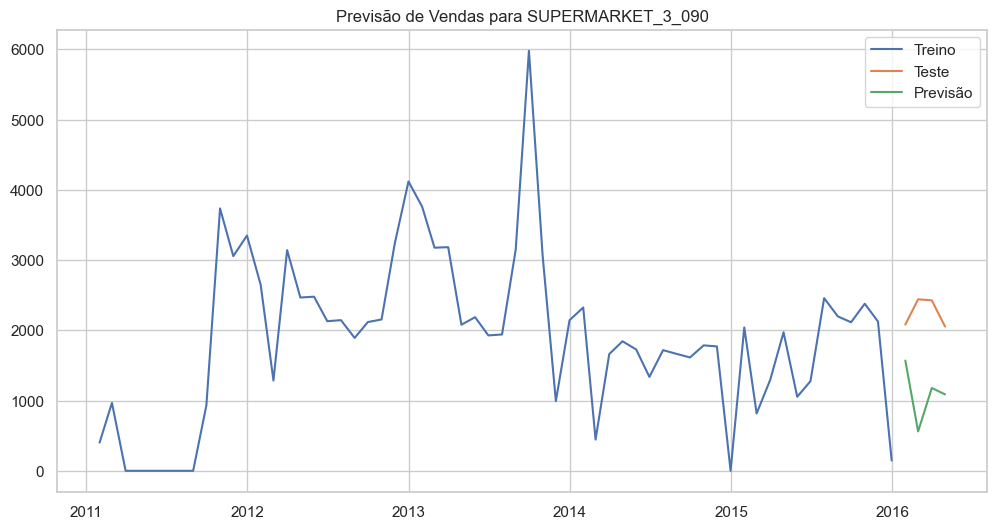

ValueError: Provided exogenous values are not of the appropriate shape. Required (5, 6), got (4, 6).

In [23]:
# Criar um dicionário para armazenar as previsões futuras
future_forecasts = {}

for item in top_items:
    print(f'Treinando modelo para o item: {item}')
    item_data = monthly_sales[monthly_sales['item'] == item]
    forecast = train_and_forecast(item_data, item)
    future_forecasts[item] = forecast

## Análise dos Resultados

In [24]:
# Pprevisão para um item
item_to_view = top_items[0]  # Primeiro item da lista
print(f'Previsão para os próximos 28 dias para o item {item_to_view}:')
print(future_forecasts[item_to_view])


Previsão para os próximos 28 dias para o item SUPERMARKET_3_090:


KeyError: 'SUPERMARKET_3_090'

# Prophet

c:\Users\rpiaz\Desenvolvimento\DSMarket\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


  Using cached tqdm-4.66.5-py3-none-any.whl.metadata (57 kB)
   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ---------------------- ----------------- 7.3/13.3 MB 45.4 MB/s eta 0:00:01
   ---------------------------------------- 13.3/13.3 MB 41.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   ---------------------------------------- 1.1/1.1 MB 26.5 MB/s eta 0:00:00
Using cached tqdm-4.66.5-py3-none-any.whl (78 kB)
Note: you may need to restart the kernel to use updated packages.


14:44:41 - cmdstanpy - INFO - Chain [1] start processing
14:44:41 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\rpiaz\Desenvolvimento\DSMarket\.venv\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


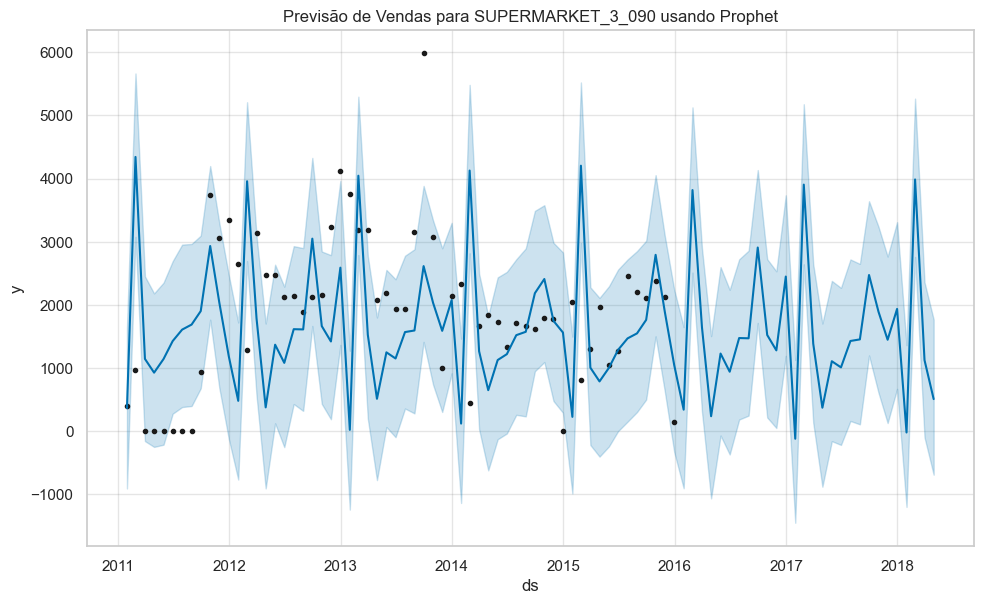

In [25]:
%pip install prophet
from prophet import Prophet

def train_and_forecast_prophet(item_df, item_name):
    # Preparar o DataFrame no formato esperado pelo Prophet
    df_prophet = item_df.reset_index()[['date', 'sales']].rename(columns={'date': 'ds', 'sales': 'y'})
    
    # Adicionar eventos como regressores
    exog_vars = [col for col in item_df.columns if 'event_' in col]
    for var in exog_vars:
        df_prophet[var] = item_df[var].values
    
    # Dividir em treino e teste
    train = df_prophet[df_prophet['ds'].dt.year < 2016]
    test = df_prophet[df_prophet['ds'].dt.year == 2016]
    
    # Configurar o modelo Prophet
    model = Prophet()
    for var in exog_vars:
        model.add_regressor(var)
    
    # Treinar o modelo
    model.fit(train)
    
    # Fazer previsões
    future = model.make_future_dataframe(periods=28, freq='M')
    for var in exog_vars:
        future[var] = 0  # Ajuste conforme os eventos futuros
    forecast = model.predict(future)
    
    # Plotar os resultados
    model.plot(forecast)
    plt.title(f'Previsão de Vendas para {item_name} usando Prophet')
    plt.show()
    
    return forecast[['ds', 'yhat']]

# Aplicar a função para um item
forecast_prophet = train_and_forecast_prophet(item_data, item_to_view)
